# Humanoid Detection and Skeleton Landmarks

### Description
This notebook is a demonstration of applied AI using a pre-trained model to:

- Detect the presence of a **humanoid subject** with a degree of confidence
- Identify and localize **skeleton key landmarks** across the body

The goal of this study is to evaluate potential tools for the downstream task of **Automatic Rigging of 3D Humanoid Models** for animation or game pipelines.

We use a **pretrained YOLOv8 pose model** to extract landmark information from a set of test images.

### Use Case
Our first example is a simple T-Pose of a Human Man; showing good test results. Our later examples show the models applied to humanoids/creatures that are assumed to be excluded from the original COCO dataset which consists of real human subjects in real world scenes. These examples prove to be difficult for the model to detect landmarks accurately.

### The Model: Ultralytics YOLOv8 Pose Detection

| Variant | Parameters | Description |
|---------|------------|-------------|
| `11n`   | ~3 Million | Lightweight, fast, lower accuracy |
| `11x`   | ~60 Million | Heavyweight, slower, higher accuracy |

### The Training Dataset

- **COCO (Common Objects in Context)** – Pose Detection Subset
- **17 Keypoints**:
  - Nose, eyes, ears, shoulders, elbows, wrists, hips, knees, and ankles

### The Testing Dataset

- Images captured from:
  - Google Search (general humanoid examples)
  - [Meshy.ai](https://meshy.ai/) (stylized digital avatars)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from ultralytics import YOLO

In [2]:
model_11n = YOLO("yolo11n-pose.pt")
model_11x = YOLO("yolo11x-pose.pt")

In [20]:
human_file_path = os.getcwd() + "\\example_images\\t_pose.jpg"
print(human_file_path)

examples = os.listdir(os.getcwd() + "\\example_images\\")

c:\Users\SLZ-20\Desktop\SkeletonTracking\example_images\t_pose.jpg


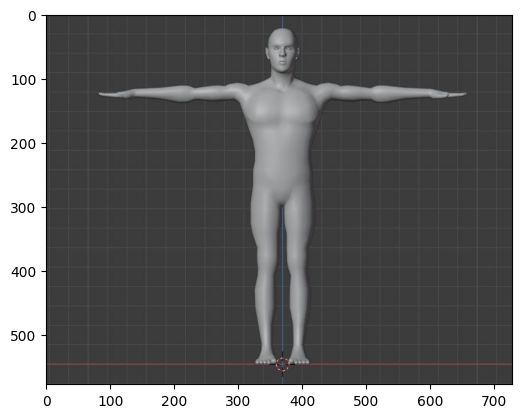

In [4]:
human_im_arr = np.asarray(Image.open(human_file_path))
plt.imshow(human_im_arr)

In [5]:
results_11n = model_11n(human_im_arr)  #smaller model
results_11x = model_11x(human_im_arr)  #larger model


0: 512x640 1 person, 60.1ms
Speed: 2.9ms preprocess, 60.1ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 person, 281.3ms
Speed: 1.3ms preprocess, 281.3ms inference, 0.5ms postprocess per image at shape (1, 3, 512, 640)


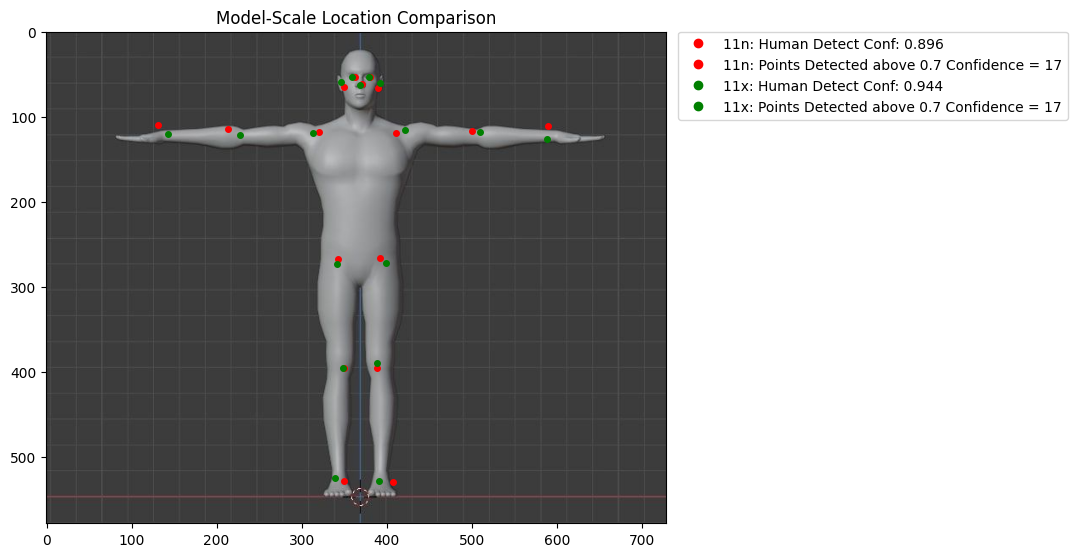

In [6]:
plt.figure(figsize=(8, 8))
plt.imshow(human_im_arr)
ax = plt.gca()
plt.title("Model-Scale Location Comparison")
conf_thresh = 0.7


def PlotLandmarks(res, plt_thresh, plt_ax, plt_color, lbl):
    kp_count = 0
    for result in res:
        bbox = result.boxes
        box_class = bbox.cls
        if (bbox.conf.nelement() == 0):
            plt_ax.plot([], [], plt_color, label=f"{lbl}: Human Detect Conf: {0:.3f}")

        else:
            box_conf = bbox.conf.cpu().numpy()[0]
            plt_ax.plot([], [], plt_color, label=f"{lbl}: Human Detect Conf: {box_conf:.3f}")
            
            kps = result.keypoints
            if kps is not None:
                coords = kps.xy.cpu().numpy()  # [n_dets, n_joints, 2]
                confs = kps.conf.cpu().numpy()

                for pose, pose_conf in zip(coords, confs):
                    for (x, y), c in zip(pose, pose_conf):
                        if c > plt_thresh:  # threshold confidence
                            kp_count+=1
                            #ax.text (x, y -2, f" Conf: {c:.3g}", horizontalalignment=side)
                            plt_ax.plot(x, y, plt_color, markersize=4)

    plt_ax.plot([], [], plt_color, label=f"{lbl}: Points Detected above {plt_thresh} Confidence = {kp_count:.0f}")
    plt_ax.legend(        
        loc='upper left',   
        bbox_to_anchor=(1.02, 1), 
        borderaxespad=0,
        frameon=True)

PlotLandmarks(results_11n, conf_thresh, ax, "ro", "11n")
PlotLandmarks(results_11x, conf_thresh, ax, "go", "11x")

(-0.5, 728.5, 577.5, -0.5)

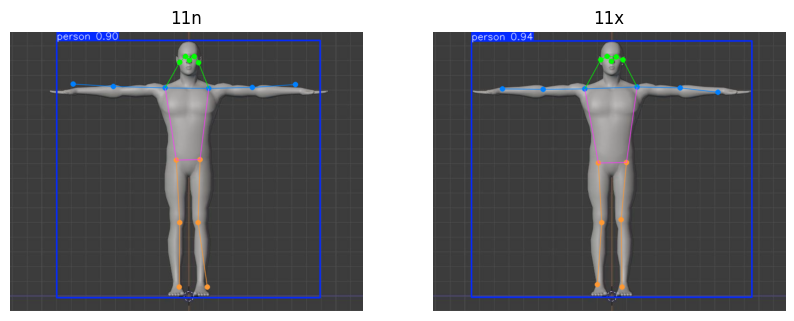

In [ ]:
output_dir = "//ModelOutputs//"
model_ouputs = os.listdir(os.getcwd() + output_dir)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(plt.imread(os.getcwd() + output_dir + model_ouputs[0]))
axs[0].set_title("11n")
axs[0].axis("off")
axs[1].imshow(plt.imread(os.getcwd() + output_dir + model_ouputs[1]))
axs[1].set_title("11x")
axs[1].axis("off")

In [12]:
def StoreConfs(model, collection):
    for result in model:
        kps   = result.keypoints
        if kps is not None:
            confs = kps.conf 
            collection.append(confs)
            
        result.show()   
        
confs_11n = list()
confs_11x = list()

StoreConfs(results_11n, confs_11n)
StoreConfs(results_11x, confs_11x)

confs_11n_arr = np.array(confs_11n)[0, 0]
confs_11x_arr = np.array(confs_11x)[0, 0]

score_delta = np.array(confs_11n) - np.array(confs_11x)
avg_delta = score_delta.mean()


In [17]:
def PlotConfs(confs_11n_arr_norm, confs_11x_arr_norm, avg_delta, minVal, maxVal):

    labels = [ "nose", "left_eye", "right_eye", "left_ear", "right_ear",
            "left_shoulder", "right_shoulder", "left_elbow", "right_elbow",
            "left_wrist", "right_wrist", "left_hip", "right_hip", "left_knee",
            "right_knee", "left_ankle", "right_ankle" ]

    x_axis = np.arange(len(labels))
    print(len(x_axis))

    width = 0.35
    plt.bar(x_axis, confs_11n_arr_norm, width, label='11N', color='skyblue')
    plt.bar(x_axis + width, confs_11x_arr_norm, width, label='11X', color='salmon')
    plt.bar([], [], label=f"Min Conf: {minVal:.3f}", color='white')
    plt.bar([], [], label=f"Max Conf: {maxVal:.3f}", color='white')
    plt.bar([], [], label=f"Avg Conf Delta: {avg_delta:.3f}", color='white')

    plt.xticks(x_axis, labels, rotation=45)
    plt.ylabel("Confidence Score")
    plt.title("Pretrain Model Scale Comparison: Nomalized Confidence Scores on Digital Human")
    plt.tight_layout()
    plt.legend(
        loc='upper left',   
        bbox_to_anchor=(1.02, 1), 
        borderaxespad=0,
        frameon=True
    )
    plt.show()

17


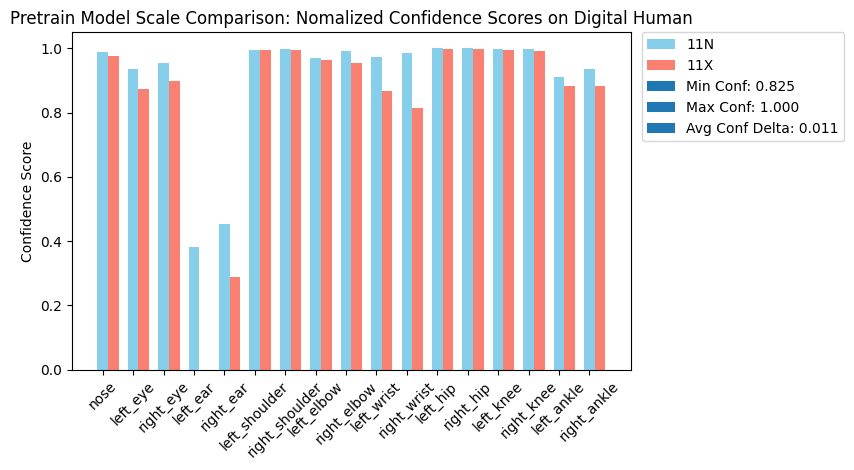

In [18]:
minVal = min(min(confs_11n_arr), min(confs_11x_arr))
maxVal = max(max(confs_11n_arr), max(confs_11x_arr))

confs_11n_arr_norm = (confs_11n_arr - minVal) / (maxVal - minVal)
confs_11x_arr_norm = (confs_11x_arr - minVal) / (maxVal - minVal)

PlotConfs(confs_11n_arr_norm, confs_11x_arr_norm, avg_delta, minVal, maxVal)

In [15]:
def RunPipeline(img, conf_thresh):
    results_11n = model_11n(img)  #smaller model
    results_11x = model_11x(img) 

    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    ax = plt.gca()
    plt.title("Model-Scale Location Comparison")

    PlotLandmarks(results_11n, conf_thresh, ax, "ro", "11n")
    PlotLandmarks(results_11x, conf_thresh, ax, "go", "11x")

c:\Users\SLZ-20\Desktop\SkeletonTracking\example_images\cat_standing.png
(564, 396, 3)

0: 640x480 (no detections), 62.1ms
Speed: 1.2ms preprocess, 62.1ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 (no detections), 295.4ms
Speed: 1.1ms preprocess, 295.4ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 480)
c:\Users\SLZ-20\Desktop\SkeletonTracking\example_images\kid_tpose_back.png
(714, 690, 3)

0: 640x640 1 person, 56.4ms
Speed: 2.0ms preprocess, 56.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 415.4ms
Speed: 2.3ms preprocess, 415.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
c:\Users\SLZ-20\Desktop\SkeletonTracking\example_images\kid_tpose_side.png
(676, 364, 3)

0: 640x352 1 person, 37.1ms
Speed: 0.7ms preprocess, 37.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 1 person, 242.8ms
Speed: 1.4ms preprocess, 242.8ms inference, 0.5ms postpro

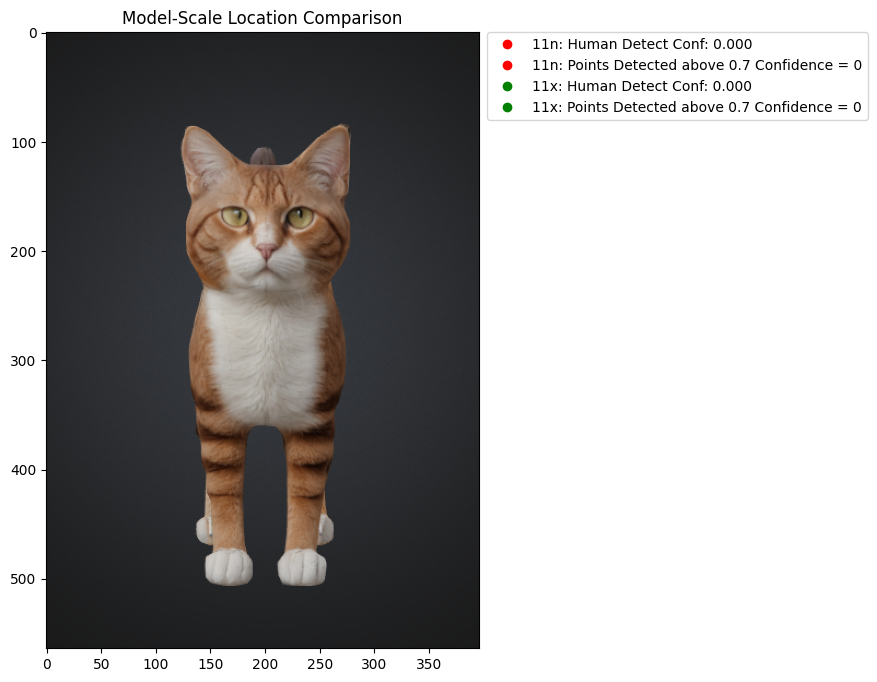

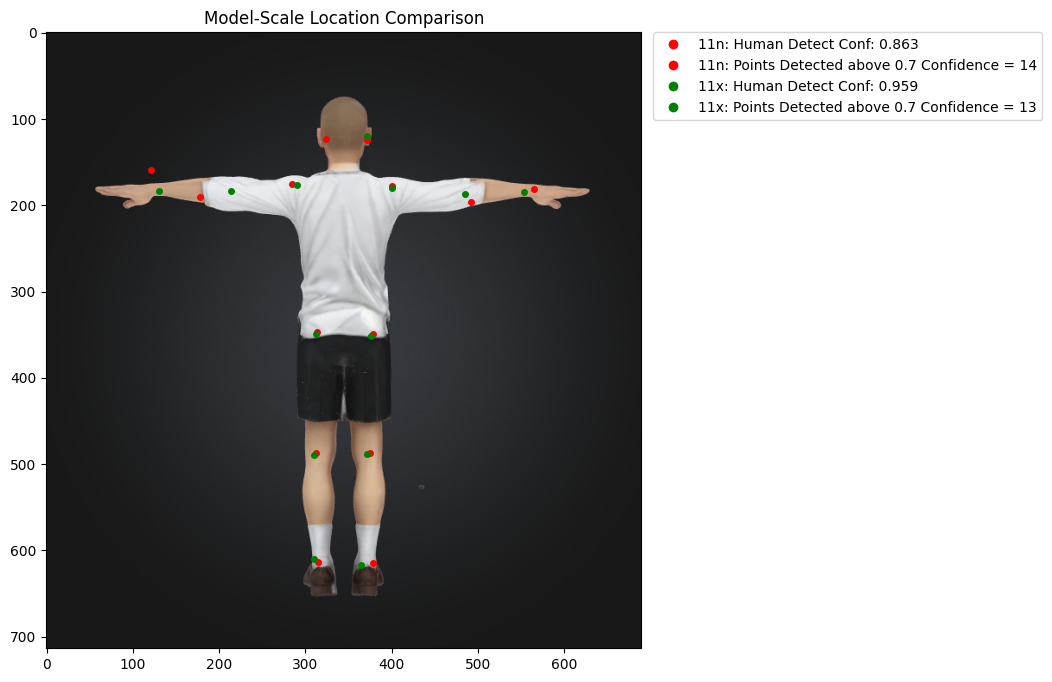

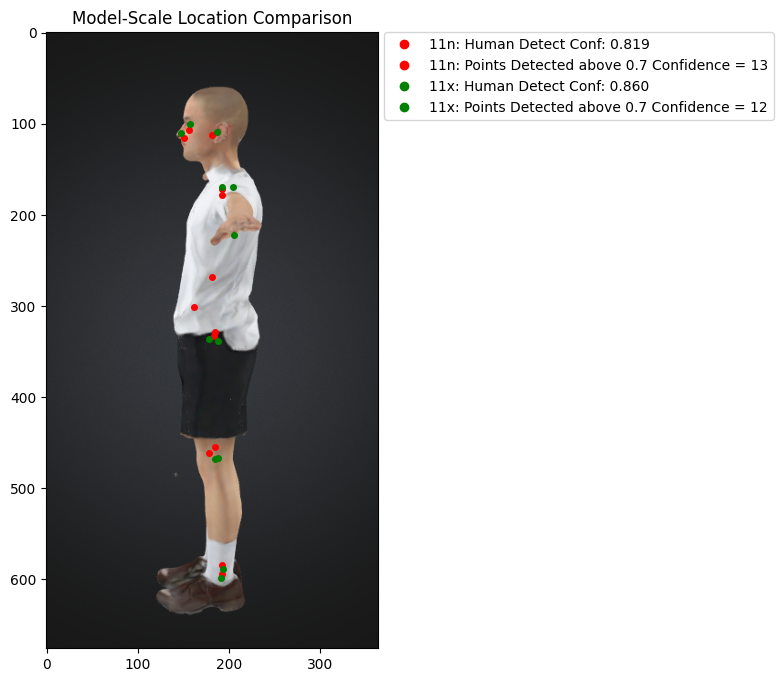

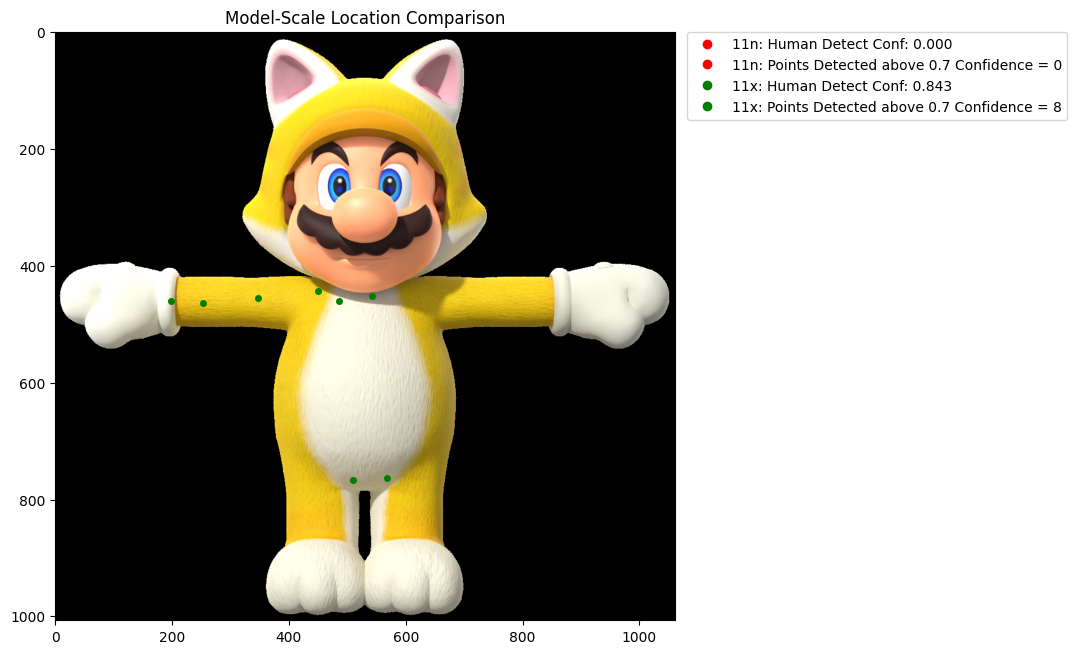

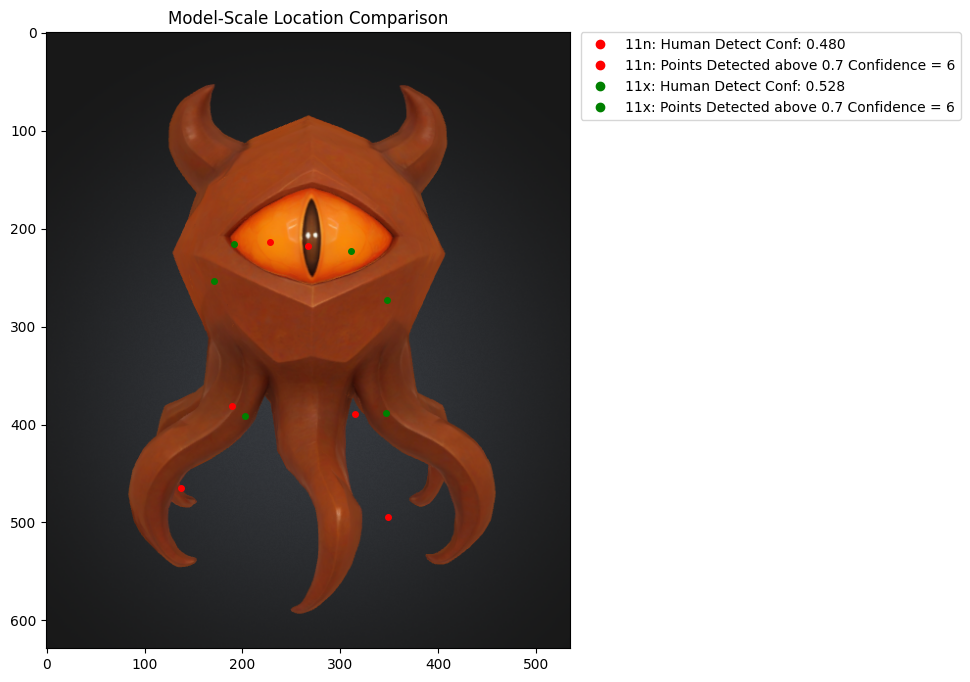

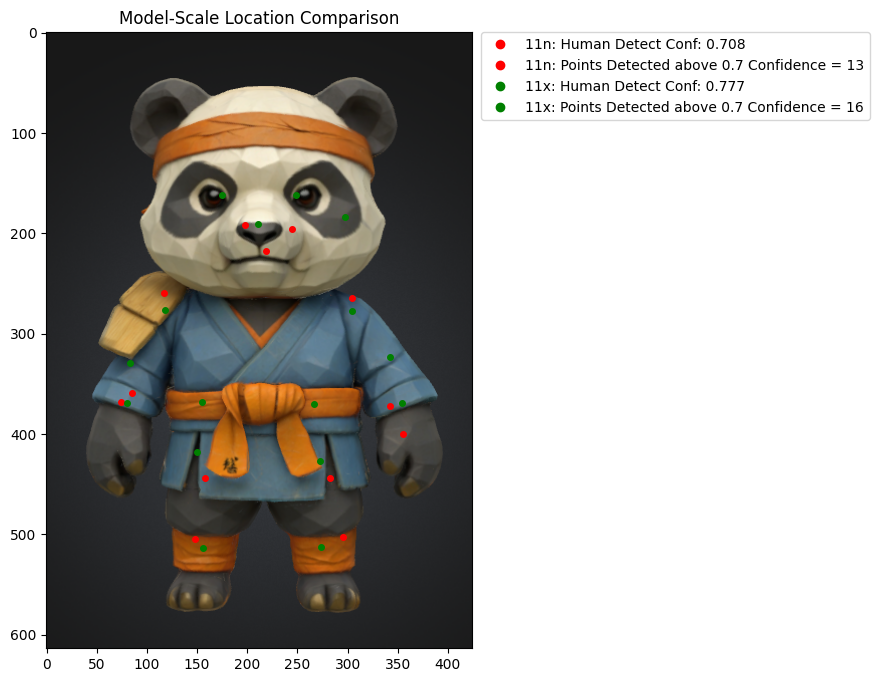

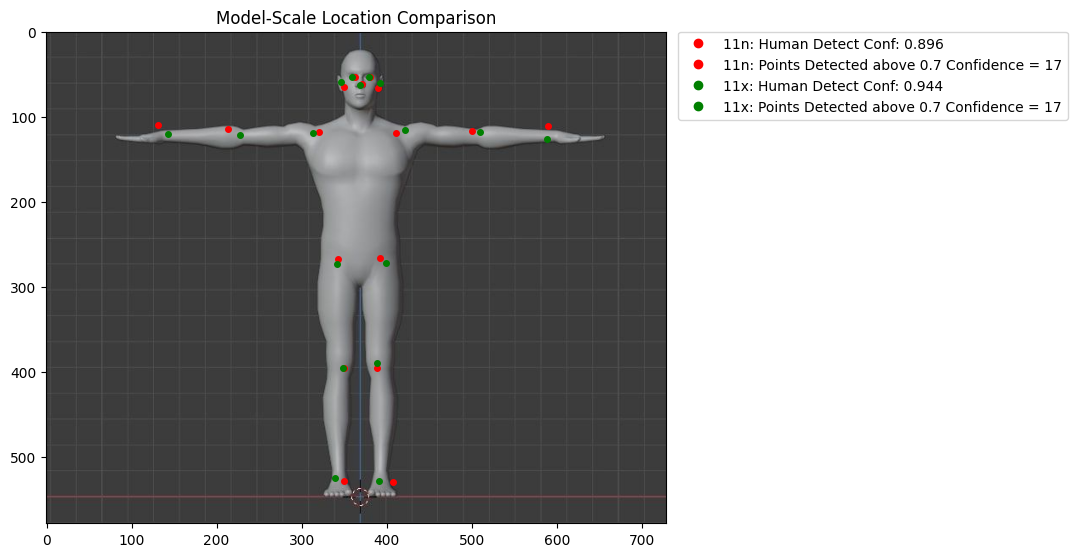

In [21]:
kp_threshold = 0.7

for sample in examples:
    sample_path = os.getcwd() + "\\example_images\\" + sample
    print(sample_path)
    sample_arr = np.asarray(Image.open(sample_path).convert('RGB'))
    print(sample_arr.shape)
    RunPipeline(sample_arr, kp_threshold)

### Findings

Our initial observations show that for a digital male in a T-pose, both models produce fairly accurate results, with the larger **11x model** performing best in terms of qualitative assessment.

- **Human Subjects:** Both models confidently identify the subject as a humanoid, which is expected given their training on real human data.
  
- **Digital Cat:** Both models correctly reject the subject as a non-humanoid, assigning near-zero confidence.

- **Mario in Cat Costume:** Only the larger model (`11x`) is able to recognize the subject as humanoid. However, it still fails to accurately detect all key landmarks.

- **Panda Humanoid:** Both models correctly classify the subject as humanoid and detect a majority of the landmarks, but struggle particularly with facial and hip keypoints.

- **Squid Creature:** Both models hover around 50% confidence and fail to detect many of the required landmarks.

---

### Improvements to the Study

To improve this study, a dataset with ground truth annotations for the digital landmarks could be used to perform **quantitative** evaluation of model performance. Additional improvements include:

- Testing on a wider range of poses and body orientations
- Evaluating alternative approaches, such as:
  - Google MediaPipe
  - Models trained specifically on synthetic or digital human datasets
  - Non-neural approaches (e.g., `skimage.morphology.skeletonize` combined with custom vertex detection algorithms)

---

### Conclusion

This study highlights that neural network models trained exclusively on real-world data have **limited generalization** when applied to digital or stylized humanoid subjects. While pretrained models like YOLOv8 can be useful for the downstream task of automatic rigging, their effectiveness depends heavily on the similarity between the training data and the target domain. 

For digital rigging workflows, these models may serve as a **baseline or bootstrapping tool**, but additional training on domain-specific data is likely necessary for production-quality results.


